In [90]:
import os
import time
import pandas as pd
import numpy as np
from scipy.stats import uniform
import matplotlib.pyplot as plt
import matplotlib_inline
import seaborn as sns
import mglearn

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR

# import helperfunctions
from helperfunctions import fun_load_file, fun_preprocessing, fun_split_X_y
from helperfunctions import fun_convert_time, fun_fit_gridsearch_time
from helperfunctions import fun_train_score, fun_test_score, fun_best_model
from helperfunctions import fun_feature_weights, plot_feature_importances, plot_heatmap

# start time count and load data
start_script = time.time()
data = fun_load_file(path='..\\01_data\\01_TSP', name='combined_train_instances_dennis.xlsx')
train_data = fun_preprocessing(data)
X, y = fun_split_X_y(train_data)

# create a train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=0)

# create a smaller train set for svm
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X, y, test_size=0.99, random_state=0)

# save number of features and train sizes
n_features = X_train.shape[1]
train_size = f'{int(np.round(100 * len(X_train)/len(X)))} %'
train_size_small = f'{int(np.round(100 * len(X_train_small)/len(X)))} %'

# **KNN**

In [31]:
# grid search cross validation
param_grid = {'n_neighbors': list(np.arange(start=1, stop=11))}

grid_search = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=param_grid, cv=5,
                    scoring='neg_mean_absolute_percentage_error', 
                    verbose=False, n_jobs=1)
fit_time = fun_fit_gridsearch_time(grid_search, X_train, y_train)

# view results of grid search cross validation
MAPE, RMSE = fun_best_model(grid_search, X_train, y_train, view_results_df=True, return_scores=True)

# save results to dictionary
results_dict = {}
results_dict['KNN'] = {'MAPE': MAPE, 'RMSE': RMSE, 'Fit gird searach time': fit_time, 'Train size': train_size}

  CV MAPE train data: 57.4517 %
  CV RMSE train data: 9.6275

  Best model / parameter combination:
   {'n_neighbors': 3}

Cross validation scores of all parameter combinations:


,params,mean_test_score
0,{'n_neighbors': 1},-0.615940
1,{'n_neighbors': 2},-0.576546
2,{'n_neighbors': 3},-0.574517
3,{'n_neighbors': 4},-0.580057
4,{'n_neighbors': 5},-0.587618
5,{'n_neighbors': 6},-0.595705
6,{'n_neighbors': 7},-0.606130
7,{'n_neighbors': 8},-0.617253
8,{'n_neighbors': 9},-0.626867
9,{'n_neighbors': 10},-0.637577


# **Linear Models**

**Linear Regression**

In [32]:
# create model and fit it on train set (default parameters)
lr = LinearRegression()
lr.fit(X_train, y_train)

# estimate model performance with cross validation on the train set (scoring: MAPE and RMSE)
MAPE, RMSE, computation_time = fun_train_score(lr, X_train, y_train, cv=10, return_results=True)

# save results to dictionary
results_dict['Linear Regression'] = {'MAPE': MAPE, 'RMSE': RMSE, 'Fit gird searach time': computation_time, 'Train size': train_size} #no parameters, no grid search only cv

# top ten absolute feature weights
fun_feature_weights(lr, X_train)

  CV MAPE train data:  16.4223 %
  CV RMSE train data:  3.293
  CV computation time: 5 sec

Feature weights: 
Mean distance to other customers_ratio    17.419001
Distance_to_Depot_Ratio                   13.228763
Fourth_Closest_Customer_Distance_Ratio     2.817453
Distance_to_gravity_center_ratio           2.253190
Marginal_Cost_ratio                        1.943119
Second_Closest_Customer_Distance_Ratio     1.806364
Number Clusters                            1.478822
Savings_ratio                              1.473507
cluster_distance_to_depot_ratio            1.259898
Number Customers                           1.022066
dtype: float64

Bias: -10.369540827248336


**Rigde Regression (L2-Regularization)**

In [33]:
# grid search cross validation
param_grid = {'alpha': [0, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_search = GridSearchCV(estimator=Ridge(), param_grid=param_grid, cv=5,
                    scoring='neg_mean_absolute_percentage_error', 
                    verbose=False, n_jobs=1)
fit_time = fun_fit_gridsearch_time(grid_search, X_train, y_train)

# view results of grid search cross validation
MAPE, RMSE = fun_best_model(grid_search, X_train, y_train, view_results_df=True, return_scores=True)

# save results to dictionary
results_dict['Ridge Regression'] = {'MAPE': MAPE, 'RMSE': RMSE, 'Fit gird searach time': fit_time, 'Train size': train_size}

# top ten absolute feature weights
fun_feature_weights(grid_search.best_estimator_, X_train)

  CV MAPE train data: 16.4242 %
  CV RMSE train data: 3.2891

  Best model / parameter combination:
   {'alpha': 10}

Cross validation scores of all parameter combinations:


,params,mean_test_score
0,{'alpha': 0},-0.164359
1,{'alpha': 0.001},-0.164359
2,{'alpha': 0.01},-0.164359
3,{'alpha': 0.1},-0.164362
4,{'alpha': 1},-0.164386
5,{'alpha': 10},-0.164242
6,{'alpha': 100},-0.164436
7,{'alpha': 1000},-0.171855



Feature weights: 
Distance_to_Depot_Ratio                   11.784495
Mean distance to other customers_ratio     5.036944
Distance_to_gravity_center_ratio           2.427646
Fourth_Closest_Customer_Distance_Ratio     2.342283
cluster_distance_to_depot_ratio            2.236307
Marginal_Cost_ratio                        1.909659
Number Clusters                            1.619893
Second_Closest_Customer_Distance_Ratio     1.580805
Savings_ratio                              1.460214
Number Customers                           1.077699
dtype: float64

Bias: -2.8122674287348417


**Lasso Regression (L1-Regularization)**

In [34]:
# grid search cross validation
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10], #higher alpha means higher regularization and lower model complexity (less overfitting)
              'max_iter': [10000]}

grid_search = GridSearchCV(estimator=Lasso(), param_grid=param_grid, cv=5,
                    scoring='neg_mean_absolute_percentage_error', 
                    verbose=False, n_jobs=-1)
fit_time = fun_fit_gridsearch_time(grid_search, X_train, y_train)

# view results of grid search cross validation
MAPE, RMSE = fun_best_model(grid_search, X_train, y_train, view_results_df=True, return_scores=True)

# save results to dictionary
results_dict['Lasso Regression'] = {'MAPE': MAPE, 'RMSE': RMSE, 'Fit gird searach time': fit_time, 'Train size': train_size}

# top ten absolute feature weights
fun_feature_weights(grid_search.best_estimator_, X_train)

  CV MAPE train data: 16.4379 %
  CV RMSE train data: 3.2846

  Best model / parameter combination:
   {'alpha': 0.0001, 'max_iter': 10000}

Cross validation scores of all parameter combinations:


,params,mean_test_score
0,"{'alpha': 0.0001, 'max_iter': 10000}",-0.164379
1,"{'alpha': 0.001, 'max_iter': 10000}",-0.164536
2,"{'alpha': 0.01, 'max_iter': 10000}",-0.166093
3,"{'alpha': 0.1, 'max_iter': 10000}",-0.169992
4,"{'alpha': 1, 'max_iter': 10000}",-0.195641
5,"{'alpha': 10, 'max_iter': 10000}",-0.198838



Feature weights: 
Mean distance to other customers_ratio    16.449296
Distance_to_Depot_Ratio                   13.215876
Fourth_Closest_Customer_Distance_Ratio     2.803706
Marginal_Cost_ratio                        1.938737
Distance_to_gravity_center_ratio           1.831821
Second_Closest_Customer_Distance_Ratio     1.790404
Number Clusters                            1.486619
Savings_ratio                              1.469912
cluster_distance_to_depot_ratio            1.261492
Number Customers                           1.024799
dtype: float64

Bias: -9.839943503588522


**Support Vector Machine (SVM)**

Method: StandardScaler()
  CV MAPE train data: 18.4314 %
  CV RMSE train data: 3.6104

  Best model / parameter combination:
   {'svm__C': 0.1}

Method: MinMaxScaler()
  CV MAPE train data: 18.3532 %
  CV RMSE train data: 3.5135

  Best model / parameter combination:
   {'svm__C': 10}

Method: RobustScaler()
  CV MAPE train data: 18.3391 %
  CV RMSE train data: 3.5094

  Best model / parameter combination:
   {'svm__C': 1}


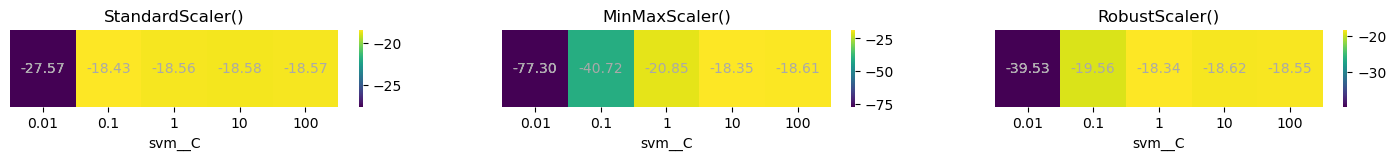

In [35]:
# create parameter grid
param_grid = {'svm__C': [0.01, 0.1, 1, 10, 100]}

# compare the scaling methods
scores_list = []
best_MAPE = 100
for scaler in [StandardScaler(), MinMaxScaler(), RobustScaler()]:
    
    # create pipeline
    pipe = Pipeline(steps=[('Scaler', scaler), ('svm', SVR(kernel='linear'))])

    # grid search cross validation with pipeline as estimator
    grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=3,
                               scoring='neg_mean_absolute_percentage_error', 
                               verbose=False, n_jobs=-1)
    fit_time = fun_fit_gridsearch_time(grid_search, X_train_small, y_train_small)

    # estimate model performance with cross validation on the train set (scoring: MAPE and RMSE)
    if (not isinstance(scaler, StandardScaler)): print('')
    print('Method:', scaler)
    MAPE, RMSE = fun_best_model(grid_search, X_train_small, y_train_small, view_results_df=False, return_scores=True)
    
    # create a data frame with grid search cv results and add it to scores_list
    results_df = pd.DataFrame(grid_search.cv_results_)
    scores_list.append(np.array(results_df['mean_test_score']) * 100)

    # save best result
    if MAPE < best_MAPE:
        best_MAPE = MAPE
        best_RMSE = RMSE
        best_fit_time = fit_time

# view heatmap of results
plot_heatmap(scores_list=scores_list, param_grid=param_grid, different_scalers=True)

# save results to dictionary
results_dict['Linear SVM'] = {'MAPE': best_MAPE, 'RMSE': best_RMSE, 'Fit gird searach time': best_fit_time, 'Train size': train_size_small}

# **Compare Results**

In [36]:
display(pd.DataFrame(results_dict).sort_values(by='MAPE', axis=1))
print('Total script computation time:', fun_convert_time(start=start_script, end=time.time()))

,Linear Regression,Ridge Regression,Lasso Regression,Linear SVM,KNN
MAPE,16.4223,16.4242,16.4379,18.3391,57.4517
RMSE,3.293,3.2891,3.2846,3.5094,9.6275
Fit gird searach time,5 sec,1 sec,"1 min, 9 sec",5 sec,"1 min, 15 sec"
Train size,25 %,25 %,25 %,1 %,25 %


Total script computation time: 3 min, 42 sec
